### Transfer Learning

`Nome`: Pedro Henrique Gomes Peixoto Januario

`DRE`: 119042303


`Nome` : Mayara Aragão

`DRE`: 115060969




Para essa lista, optamos por usar o mesmo dataset anterior para comparar o modelo original com o modelo obtido por transfer learning.

In [ ]:
import numpy as np
import pandas as pd
import cv2,os,pathlib
import matplotlib.pyplot as plt

In [ ]:
# Importando dataset atraves da API do kaggle:
from google.colab import files
files.upload() #this will prompt you to update the json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Saving kaggle.json to kaggle.json
kaggle.json
100% 3.24G/3.24G [00:50<00:00, 36.5MB/s]
100% 3.24G/3.24G [00:50<00:00, 68.7MB/s]


In [ ]:
!unzip -q a-large-scale-fish-dataset.zip -d nemo_dataset

In [ ]:
%cd nemo_dataset/Fish_Dataset/Fish_Dataset

/content/nemo_dataset/Fish_Dataset/Fish_Dataset


In [ ]:
!ls

'Black Sea Sprat'   README.txt	     Segmentation_example_script.m
'Gilt-Head Bream'  'Red Mullet'      Shrimp
'Hourse Mackerel'  'Red Sea Bream'  'Striped Red Mullet'
 license.txt	   'Sea Bass'	     Trout


In [ ]:
datasetPath = pathlib.Path()
## Listando os Paths para as imagens, testando extensoes jpg e png
allImages = list(datasetPath.glob(r'*/*/*.jpg')) + list(datasetPath.glob(r'*/*/*.png'))

## Iniciando array das imagens e labels
images = list()
labels = list()

for img in allImages:
  imgPath = os.path.normpath(img)
  splits = imgPath.split('/')
  
  # Excluindo imagens 'Ground Truth' (GT), jogando o caminho das imgs e seus labels para os arrays 'images' e 'labels'
  if 'GT' not in splits[-2]:
    images.append(img)
    labels.append(splits[-2]) # Pegando a Label do proprio Path da imagem

In [ ]:
imgpathes = pd.Series(images).astype(str)
label = pd.Series(labels)

df = pd.concat([imgpathes,label], axis=1)
df.columns = ['Img','Label']
df

,Img,Label
0,Red Mullet/Red Mullet/00764.png,Red Mullet
1,Red Mullet/Red Mullet/00016.png,Red Mullet
2,Red Mullet/Red Mullet/00330.png,Red Mullet
3,Red Mullet/Red Mullet/00165.png,Red Mullet
4,Red Mullet/Red Mullet/00838.png,Red Mullet
...,...,...
8995,Black Sea Sprat/Black Sea Sprat/00133.png,Black Sea Sprat
8996,Black Sea Sprat/Black Sea Sprat/00783.png,Black Sea Sprat
8997,Black Sea Sprat/Black Sea Sprat/00789.png,Black Sea Sprat
8998,Black Sea Sprat/Black Sea Sprat/00649.png,Black Sea Sprat


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Separando o dataframe em Treino, Validacao e Teste (e mais shuffles)

allTrain, test = train_test_split(df,test_size=0.15,random_state=0)
train, validation = train_test_split(allTrain,test_size=0.25,random_state=0)
del allTrain

from keras.preprocessing.image import ImageDataGenerator

# Preparando o objeto para ja fazer normalizacao e uns flips aleatorios

imgDataGenObject = ImageDataGenerator(rescale=1.0/255,
                                      horizontal_flip=True,
                                      vertical_flip=True)

# Gerando os geradores:

train_generator = imgDataGenObject.flow_from_dataframe(dataframe=train,
                                                       x_col='Img',y_col='Label',
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       target_size=(224,224),
                                                       batch_size=64)
#----------------------------------
validation_generator = imgDataGenObject.flow_from_dataframe(dataframe=validation,
                                                       x_col='Img',y_col='Label',
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       target_size=(224,224),
                                                       batch_size=64)

#----------------------------------
test_generator = imgDataGenObject.flow_from_dataframe(dataframe=test,
                                                       x_col='Img',y_col='Label',
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       target_size=(224,224),
                                                       batch_size=64,
                                                      shuffle=False)


Found 5737 validated image filenames belonging to 9 classes.
Found 1913 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.


### Criando o modelo

In [ ]:
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,Flatten,Dense,Dropout

In [ ]:
checkpoint = ModelCheckpoint('/tmp/checkpoint', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlyStop = EarlyStopping(monitor='loss',patience=5,restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=1e-5, patience=3, verbose=1)
callbacks = [checkpoint,lr_reduce,earlyStop]

In [ ]:
#  Usando a VGG 19
size = (224,224,3)
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=size)
conv_base.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
conv_base.trainable = True
set_trainable = False

# Deixando o bloco 5 livre para treinamento:
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4

In [ ]:
history = model.fit(train_generator,
                   validation_data=validation_generator,
                   callbacks=callbacks,
                   epochs=15,
                   batch_size=64)

model.save('badarchitecture.h5')

Epoch 1/15
90/90 [==============================] - 174s 1s/step - loss: 1.0699 - accuracy: 0.6059 - val_loss: 8.5859 - val_accuracy: 0.4062

Epoch 00001: val_accuracy improved from -inf to 0.40617, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/15
90/90 [==============================] - 99s 1s/step - loss: 0.2293 - accuracy: 0.9189 - val_loss: 5.1156 - val_accuracy: 0.5112

Epoch 00002: val_accuracy improved from 0.40617 to 0.51124, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/15
90/90 [==============================] - 98s 1s/step - loss: 0.1101 - accuracy: 0.9662 - val_loss: 0.4022 - val_accuracy: 0.9028

Epoch 00003: val_accuracy improved from 0.51124 to 0.90277, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/15
90/90 [==============================] - 98s 1s/step - loss: 0.0871 - accuracy: 0.9746 - val_loss: 1.8426 - val_accura

# Aplicando nos dados de teste

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)
# 5 primeiros resultados
pred[:5]

array([8, 7, 4, 4, 7])

In [ ]:
LABELS = test_generator.class_indices
LABELS

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
Labeled_dict = { value: key for (key,value) in LABELS.items()}
Labeled_dict

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [ ]:
pred_labeled = [Labeled_dict[i] for i in pred]

In [ ]:
from sklearn.metrics import classification_report
y_test = list(test['Label'])

print(classification_report(y_test, pred_labeled))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       166
   Gilt-Head Bream       1.00      1.00      1.00       154
   Hourse Mackerel       1.00      1.00      1.00       136
        Red Mullet       1.00      1.00      1.00       156
     Red Sea Bream       1.00      1.00      1.00       143
          Sea Bass       1.00      1.00      1.00       150
            Shrimp       1.00      1.00      1.00       149
Striped Red Mullet       1.00      1.00      1.00       141
             Trout       1.00      1.00      1.00       155

          accuracy                           1.00      1350
         macro avg       1.00      1.00      1.00      1350
      weighted avg       1.00      1.00      1.00      1350



Text(0.5, 1.0, 'CONFUSION MATRIX')

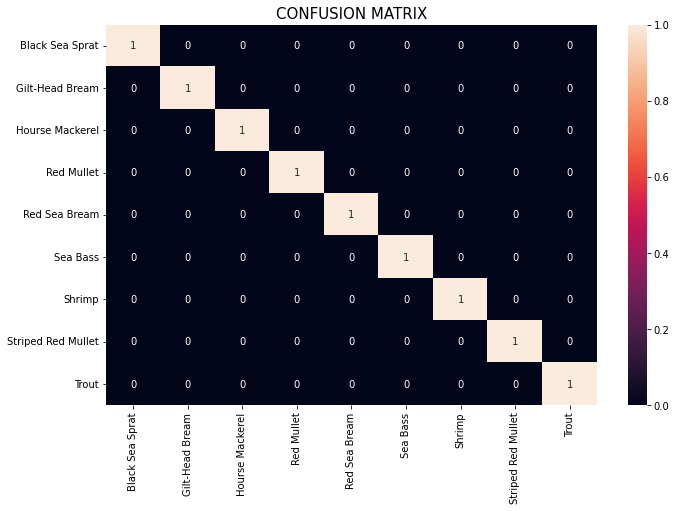

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf = confusion_matrix(y_test,pred_labeled,normalize='true',labels=list(LABELS.keys()))

plt.figure(figsize=(11,7))
sns.heatmap(cf,xticklabels=list(LABELS.keys()),yticklabels=list(LABELS.keys()),annot=True)
plt.title("CONFUSION MATRIX",fontsize=15)

In [ ]:
model.evaluate(test_generator)

22/22 [==============================] - 17s 756ms/step - loss: 3.5520e-05 - accuracy: 1.0000


[3.5520373785402626e-05, 1.0]

In [ ]:
# Comparando com o que ja tinhamos (modelo sem transfer learning)

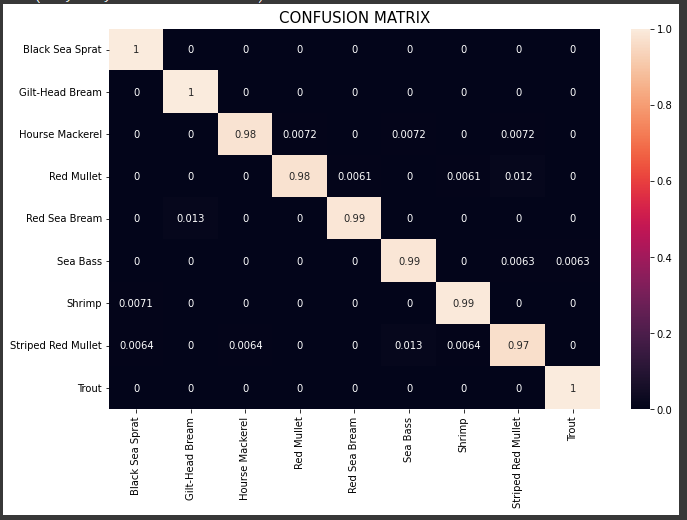

Modelo por transferlearning apresentou resultados perfeitos para esse resultado, levando a vitoria para casa sobre o nosso Nemo Finder™ T_T